In [57]:
import pandas as pd
import numpy as np
from tensorflow import keras
import os, pickle
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
from matplotlib_venn import venn2, venn2_circles
%matplotlib inline

In [46]:
# read data
debt_df, gdp_df = [pd.read_excel(filename) for filename in sorted(os.listdir(os.getcwd())) if '.xlsx' in filename]

# set index to lowercase of given index
gdp_df.index = gdp_df.rename(columns={'Unnamed: 0':'Country'}).iloc[:, 0].str.lower()
debt_df.index = debt_df.iloc[:, 0].str.lower().rename('Country')

# remove garbage data
debt_df = debt_df.iloc[1:-2]

# convert '...' to NaN
gdp_df = gdp_df.replace('...', np.NaN)

# take only data from 2011
recent_gdp_df = gdp_df.iloc[:, 1:]
recent_debt_df = debt_df.iloc[:, -10:]

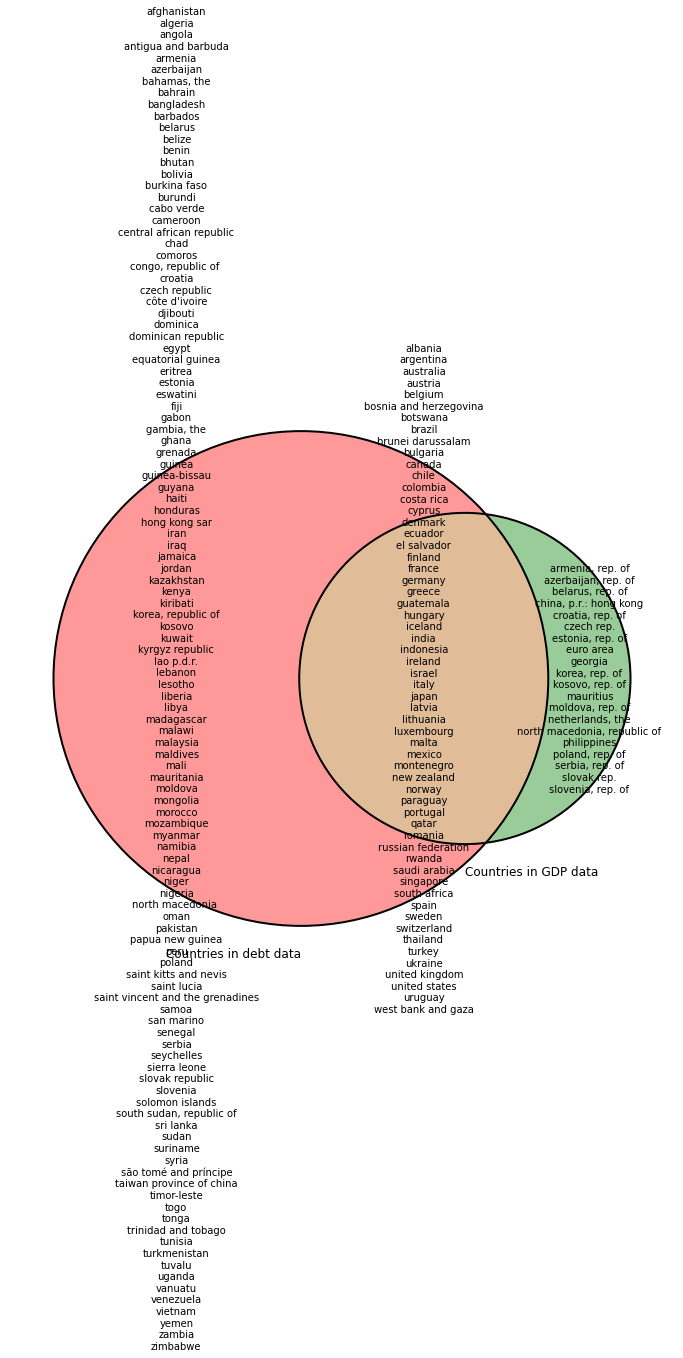

In [47]:
# fix indices that describe the same country but has different names.

# set figsize
plt.rcParams["figure.figsize"] = (12,12)

# assign strings to groups
venn_left = set(recent_debt_df.index) - set(recent_gdp_df.index)
venn_middle = set(recent_debt_df.index).intersection(recent_gdp_df.index)
venn_right = set(recent_gdp_df.index) - set(recent_debt_df.index)

# build venn diagram
v = venn2([set(recent_debt_df.index), set(recent_gdp_df.index)], set_labels=['Countries in debt data', 'Countries in GDP data'])
v.get_label_by_id('10').set_text('\n'.join(sorted(list(venn_left))))
v.get_label_by_id('01').set_text('\n'.join(sorted(list(venn_right))))
v.get_label_by_id('11').set_text('\n'.join(sorted(list(venn_middle))))

# draw outline circle
c = venn2_circles([set(recent_debt_df.index), set(recent_gdp_df.index)], linestyle='solid')

# show plot
# plt.show()

In [48]:
# convert sets to lists for indexing
venn_left_lst = list(venn_left)
venn_right_lst = list(venn_right)

# use string similarity to find matches between strings
dct = {}
for word in venn_right_lst:
    similarities = np.array([SequenceMatcher(None, word, word2).ratio() for word2 in venn_left_lst])
    most_similar_index = similarities.argsort()[-1]
    best_match = venn_left_lst[most_similar_index]
    dct[word] = best_match
df = pd.DataFrame.from_dict(dct, orient='index', columns=['best_match'])
print(df)

                                      best_match
serbia, rep. of               korea, republic of
euro area                                eritrea
armenia, rep. of              korea, republic of
netherlands, the                    bahamas, the
estonia, rep. of                         estonia
slovak rep.                      slovak republic
kosovo, rep. of               korea, republic of
azerbaijan, rep. of                   azerbaijan
czech rep.                        czech republic
belarus, rep. of                         belarus
north macedonia, republic of  korea, republic of
mauritius                             mauritania
croatia, rep. of                         croatia
georgia                                  nigeria
moldova, rep. of                         moldova
philippines                           seychelles
slovenia, rep. of                       slovenia
poland, rep. of               korea, republic of
china, p.r.: hong kong             hong kong sar
korea, rep. of      

In [49]:
# label similarity search results
df['match'] = [True, True, False, True, False, True, True, False, False, False,
               False, True, False, True, False, True, False, False, True, True]

# build rename dict for unification of country names
gdp_rename_dict = df.loc[df.match, 'best_match'].T.to_dict()

# manually fix remaining country names
gdp_rename_dict['poland, rep. of'] = 'poland'
gdp_rename_dict['armenia, rep. of'] = 'armenia'
gdp_rename_dict['kosovo, rep. of'] = 'kosovo'
gdp_rename_dict['serbia, rep. of'] = 'serbia'
gdp_rename_dict['north macedonia, rep. of'] = 'north macedonia'

# the following country names were not found in the debt dataset : 
# 'georgia', 'netherlands, the', 'euro area', 'phillipines',  'mauritius'

# unify country names in both databases
recent_gdp_df = recent_gdp_df.rename(index=gdp_rename_dict)

# save gdp_rename_dict for future use
with open('gdp_rename_dict.pkl', 'wb') as file:
    pickle.dump(recent_gdp_df, file)

In [50]:
# manually calculate growth rate of gdp
recent_gdp_growth_df = recent_gdp_df.copy()
for i in reversed(range(len(recent_gdp_df.keys()))):
    recent_gdp_growth_df.iloc[:, i] = recent_gdp_growth_df.iloc[:, i] / (recent_gdp_growth_df.iloc[:, i-1] + 1e-9)

In [51]:
def remove_outliers_df(df):
    def remove_outliers_srs(data):
        srs = data.copy()
        q1 = np.percentile(srs, 25)
        q3 = np.percentile(srs, 75)
        iqr = q3-q1

        minimum = q1 - 1.5 * iqr
        maximum = q3 + 1.5 * iqr
        srs.loc[srs < minimum] = np.NaN
        srs.loc[srs > maximum] = np.NaN
        return srs
               
    data = df.T.copy()
    for colname in data.keys():
        data[colname] = remove_outliers_srs(data[colname])
    return data.T
processed_gdp_df = remove_outliers_df(recent_gdp_df)
processed_gdp_growth_df = remove_outliers_df(recent_gdp_growth_df)

In [52]:
recent_gdp_growth_df

,2011Q1,2011Q2,2011Q3,2011Q4,2012Q1,2012Q2,2012Q3,2012Q4,2013Q1,2013Q2,...,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2
Country,,,,,,,,,,,,,,,,,,,,,
albania,NaN,1.103174,0.990508,1.088748,0.846707,1.160968,0.966980,1.049213,0.884746,1.153231,...,0.918461,1.161778,0.956483,0.988990,0.885198,1.028721,1.073640,1.053767,0.919254,NaN
argentina,NaN,1.184398,1.005973,1.039623,1.002522,1.130262,1.020267,1.053734,1.013617,1.172666,...,1.050052,1.217386,1.055873,1.117728,0.992926,0.960053,1.151781,1.174414,1.127482,NaN
armenia,NaN,1.333212,1.404949,1.049295,0.547711,1.344905,1.373814,1.016824,0.633410,1.247446,...,0.670783,1.195501,1.227402,1.093799,0.636097,1.002084,1.371825,1.089619,NaN,NaN
australia,315389.476503,1.074328,1.016899,1.041720,0.923226,1.063319,0.997122,1.043863,0.931889,1.057538,...,0.942195,1.060575,1.005258,1.037880,0.932888,0.964730,1.031094,1.087006,0.960939,1.080905
austria,NaN,1.051949,1.009764,1.039538,0.939066,1.041120,1.002392,1.049457,0.923655,1.046171,...,0.944450,1.028836,1.001309,1.047566,0.907624,0.929855,1.105056,1.023761,0.916559,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ukraine,NaN,1.199875,1.187610,0.984116,0.806111,1.183635,1.118796,0.979649,0.800971,1.168100,...,0.781463,1.137220,1.192327,1.000830,0.767250,1.024927,1.328823,1.118957,NaN,NaN
united kingdom,410689.798689,0.977553,1.010389,1.026583,1.009867,0.980627,1.021481,1.022883,1.004261,0.998130,...,1.004429,0.990725,1.013110,1.029347,0.978104,0.853346,1.117438,1.036771,0.987370,1.015857
united states,NaN,1.035433,1.008415,1.021866,0.987053,1.022432,1.008690,1.017404,0.977672,1.028220,...,0.967318,1.043877,1.010835,1.020856,0.948842,0.934471,1.086068,1.030119,0.979489,NaN


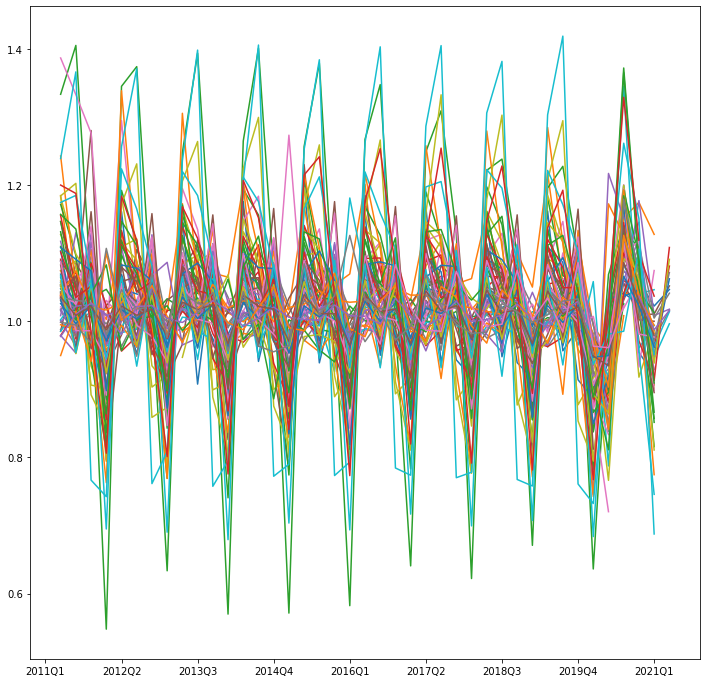

In [53]:
processed_gdp_growth_df.T.plot.line()
plt.legend().remove()
plt.show()

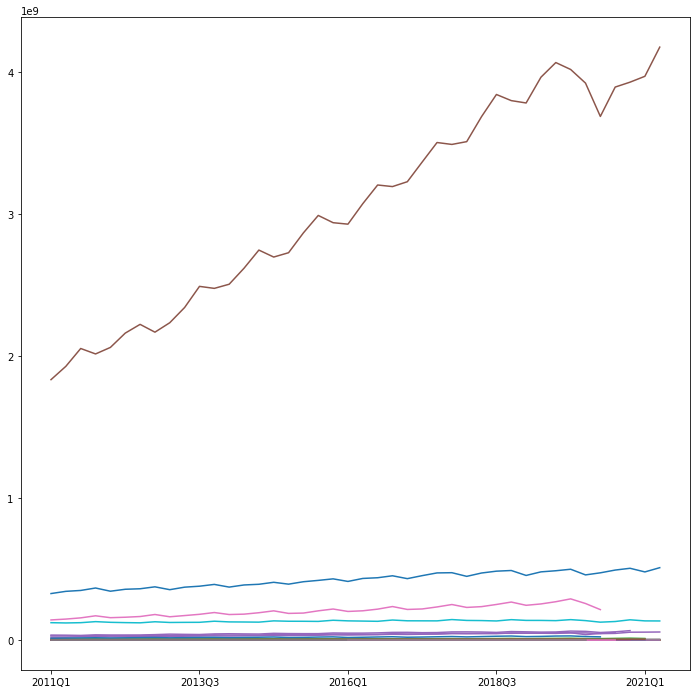

In [54]:
processed_gdp_df.T.plot.line()
plt.legend().remove()
plt.show()

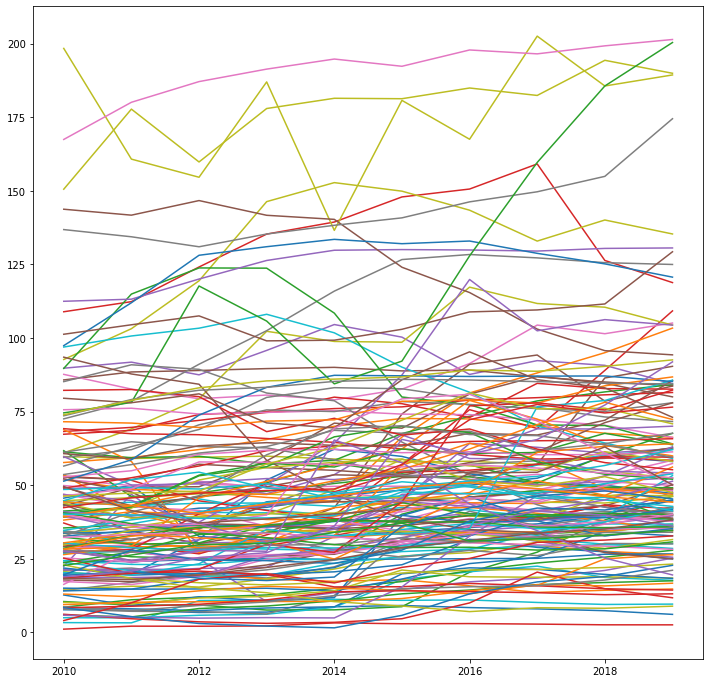

In [55]:
recent_debt_df.T.plot.line()
plt.legend().remove()
plt.show()

In [102]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(5, input_shape=(10, 1), return_sequences=True))
model.add(keras.layers.SimpleRNN(5))
model.add(keras.layers.Dense(1))
model.summary()
#model.add(keras.layers.Dense(1))

x_train, y_train = np.array([[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]), [11]
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",)
model.fit(x_train)


model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 10, 5)             35        
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, 5)                 55        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 6         
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


ValueError: in user code:

    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    c:\users\s_jenova195\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_39 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]


In [124]:
model = keras.Sequential() # Sequeatial Model 
model.add(keras.layers.LSTM(20, input_shape=(10, 1))) # (timestep, feature) 
model.add(keras.layers.Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [130]:
x_train = recent_gdp_df.fillna(0).iloc[0:4, 0:10].values.reshape(-1, 10, 1)
y_train = recent_gdp_df.fillna(0).iloc[0:4, 10].values
model.fit(x_train)

TypeError: 'NoneType' object is not callable